In [2]:
# Cell 1: Setup and Imports
import torch
import numpy as np
import json
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

# Check PyTorch and CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU (this will be slower)")

print("\n✅ Imports successful")

PyTorch version: 2.8.0+cpu
CUDA available: False
Using CPU (this will be slower)

✅ Imports successful


In [8]:
# Cell 2: Configuration
class Config:
    # Paths - Use '..' to go up one level from notebooks/
    BASE_PATH = Path('..')  # Changed from Path('.')
    DATA_PATH = BASE_PATH / 'data'
    PROCESSED_PATH = DATA_PATH / 'processed'
    EMBEDDINGS_PATH = DATA_PATH / 'embeddings'
    IMAGE_PATH = DATA_PATH / 'raw' / 'images'
    
    # Model settings
    CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 8  # Adjust based on your memory
    
    # Image settings
    IMAGE_SIZE = 224

# Create embeddings directory
Config.EMBEDDINGS_PATH.mkdir(exist_ok=True, parents=True)

print(f"✅ Configuration loaded")
print(f"BASE_PATH: {Config.BASE_PATH.resolve()}")
print(f"PROCESSED_PATH: {Config.PROCESSED_PATH.resolve()}")
print(f"Device: {Config.DEVICE}")
print(f"Model: {Config.CLIP_MODEL_NAME}")
print(f"Batch size: {Config.BATCH_SIZE}")

✅ Configuration loaded
BASE_PATH: C:\Users\00849\visual-search-engine
PROCESSED_PATH: C:\Users\00849\visual-search-engine\data\processed
Device: cpu
Model: openai/clip-vit-base-patch32
Batch size: 8


In [9]:
# Cell 3: Load CLIP Model
print("Loading CLIP model...")

model = CLIPModel.from_pretrained(Config.CLIP_MODEL_NAME)
processor = CLIPProcessor.from_pretrained(Config.CLIP_MODEL_NAME)

model = model.to(Config.DEVICE)
model.eval()

print("✅ CLIP model loaded successfully")
print(f"Model device: {next(model.parameters()).device}")

Loading CLIP model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


✅ CLIP model loaded successfully
Model device: cpu


Exception ignored in: <function tqdm.__del__ at 0x000001F5CE83DA80>
Traceback (most recent call last):
  File "C:\Users\00849\visual-search-engine\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\00849\visual-search-engine\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


In [7]:
# Debug: Check paths
import os

print("Current working directory:")
print(os.getcwd())

print("\nConfig paths:")
print(f"BASE_PATH: {Config.BASE_PATH}")
print(f"BASE_PATH absolute: {Config.BASE_PATH.resolve()}")
print(f"PROCESSED_PATH: {Config.PROCESSED_PATH}")
print(f"PROCESSED_PATH absolute: {Config.PROCESSED_PATH.resolve()}")

print("\nDoes PROCESSED_PATH exist?")
print(Config.PROCESSED_PATH.exists())

print("\nFiles in PROCESSED_PATH:")
if Config.PROCESSED_PATH.exists():
    for f in Config.PROCESSED_PATH.iterdir():
        print(f"  - {f.name}")
else:
    print("  Directory doesn't exist!")

print("\nLooking for metadata at:")
metadata_path = Config.PROCESSED_PATH / 'metadata.json'
print(metadata_path)
print(f"Exists: {metadata_path.exists()}")

Current working directory:
C:\Users\00849\visual-search-engine\notebooks

Config paths:
BASE_PATH: .
BASE_PATH absolute: C:\Users\00849\visual-search-engine\notebooks
PROCESSED_PATH: data\processed
PROCESSED_PATH absolute: C:\Users\00849\visual-search-engine\notebooks\data\processed

Does PROCESSED_PATH exist?
False

Files in PROCESSED_PATH:
  Directory doesn't exist!

Looking for metadata at:
data\processed\metadata.json
Exists: False


In [10]:
# Cell 4: Load Metadata
metadata_path = Config.PROCESSED_PATH / 'metadata.json'

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"✅ Loaded metadata for {len(metadata)} images")

✅ Loaded metadata for 25 images


In [12]:
# Cell 5: Image Embedding Function
def encode_images(image_paths, model, processor, device, batch_size=32):
    """
    Generate embeddings for a batch of images
    
    Args:
        image_paths: List of image file paths
        model: CLIP model
        processor: CLIP processor
        device: torch device
        batch_size: Batch size for processing
        
    Returns:
        numpy array of embeddings
    """
    all_embeddings = []
    
    # Process in batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Encoding images"):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        
        # Load and preprocess images
        for path in batch_paths:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading {path}: {e}")
                # Use a blank image as placeholder
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch
        inputs = processor(images=batch_images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate embeddings
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            
            # Normalize embeddings
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Move to CPU and convert to numpy
        embeddings = image_features.cpu().numpy()
        all_embeddings.append(embeddings)
    
    # Concatenate all batches
    all_embeddings = np.vstack(all_embeddings)
    
    return all_embeddings

In [13]:
# Cell 6: Text Embedding Function
def encode_text(texts, model, processor, device):
    """
    Generate embeddings for text queries
    
    Args:
        texts: List of text strings
        model: CLIP model
        processor: CLIP processor
        device: torch device
        
    Returns:
        numpy array of embeddings
    """
    inputs = processor(text=texts, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        
        # Normalize embeddings
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    return text_features.cpu().numpy()

In [14]:
# Cell 7: Generate Image Embeddings
print("Generating image embeddings...")

# For demo purposes, create dummy image paths
# In practice, use actual image paths from your dataset
# image_paths = [Config.DATA_PATH / 'raw' / 'images' / f"{item['id']}.jpg" 
#                for item in metadata]

# For this demo, we'll create synthetic embeddings
# Replace this with actual image encoding in your implementation
print("Note: Using synthetic embeddings for demo")
print("In production, uncomment the image_paths line above")

# Synthetic embeddings (512-dimensional for CLIP ViT-B/32)
embedding_dim = 512
image_embeddings = np.random.randn(len(metadata), embedding_dim).astype(np.float32)

# Normalize
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)

print(f"✅ Generated embeddings shape: {image_embeddings.shape}")

# Real implementation would be:
# image_embeddings = encode_images(image_paths, model, processor, Config.DEVICE, Config.BATCH_SIZE)

Generating image embeddings...
Note: Using synthetic embeddings for demo
In production, uncomment the image_paths line above
✅ Generated embeddings shape: (25, 512)


In [15]:
# Cell 8: Save Embeddings
embeddings_file = Config.EMBEDDINGS_PATH / 'image_embeddings.npy'
np.save(embeddings_file, image_embeddings)

print(f"✅ Embeddings saved to: {embeddings_file}")

# Save metadata with embedding indices
for i, item in enumerate(metadata):
    item['embedding_index'] = i

metadata_with_indices = Config.EMBEDDINGS_PATH / 'metadata_with_indices.json'
with open(metadata_with_indices, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata with indices saved to: {metadata_with_indices}")

✅ Embeddings saved to: ..\data\embeddings\image_embeddings.npy
✅ Metadata with indices saved to: ..\data\embeddings\metadata_with_indices.json


In [16]:
# Cell 9: Test Text Queries
print("\nTesting text query encoding...")

sample_queries = [
    "a photo of a cat",
    "sunset over mountains",
    "person walking in city",
    "delicious food on plate",
    "modern architecture"
]

text_embeddings = encode_text(sample_queries, model, processor, Config.DEVICE)

print(f"✅ Text embeddings shape: {text_embeddings.shape}")


Testing text query encoding...
✅ Text embeddings shape: (5, 512)


In [17]:
# Cell 10: Similarity Search Test
def compute_similarity(query_embedding, image_embeddings):
    """
    Compute cosine similarity between query and all images
    
    Args:
        query_embedding: Query embedding (1, dim)
        image_embeddings: Image embeddings (n, dim)
        
    Returns:
        Similarity scores (n,)
    """
    # Cosine similarity (embeddings are already normalized)
    similarities = np.dot(image_embeddings, query_embedding.T).squeeze()
    return similarities

# Test with first query
query_emb = text_embeddings[0:1]
similarities = compute_similarity(query_emb, image_embeddings)

# Get top 5 matches
top_k = 5
top_indices = np.argsort(similarities)[-top_k:][::-1]

print(f"\nQuery: '{sample_queries[0]}'")
print("\nTop 5 matches:")
for rank, idx in enumerate(top_indices, 1):
    print(f"{rank}. Image {idx}: {metadata[idx].get('description', 'N/A')} "
          f"(similarity: {similarities[idx]:.4f})")


Query: 'a photo of a cat'

Top 5 matches:
1. Image 19: people image 19 (similarity: 0.1166)
2. Image 4: city image 4 (similarity: 0.0828)
3. Image 2: city image 2 (similarity: 0.0773)
4. Image 16: nature image 16 (similarity: 0.0759)
5. Image 8: food image 8 (similarity: 0.0713)



Visualizing embedding space with PCA...


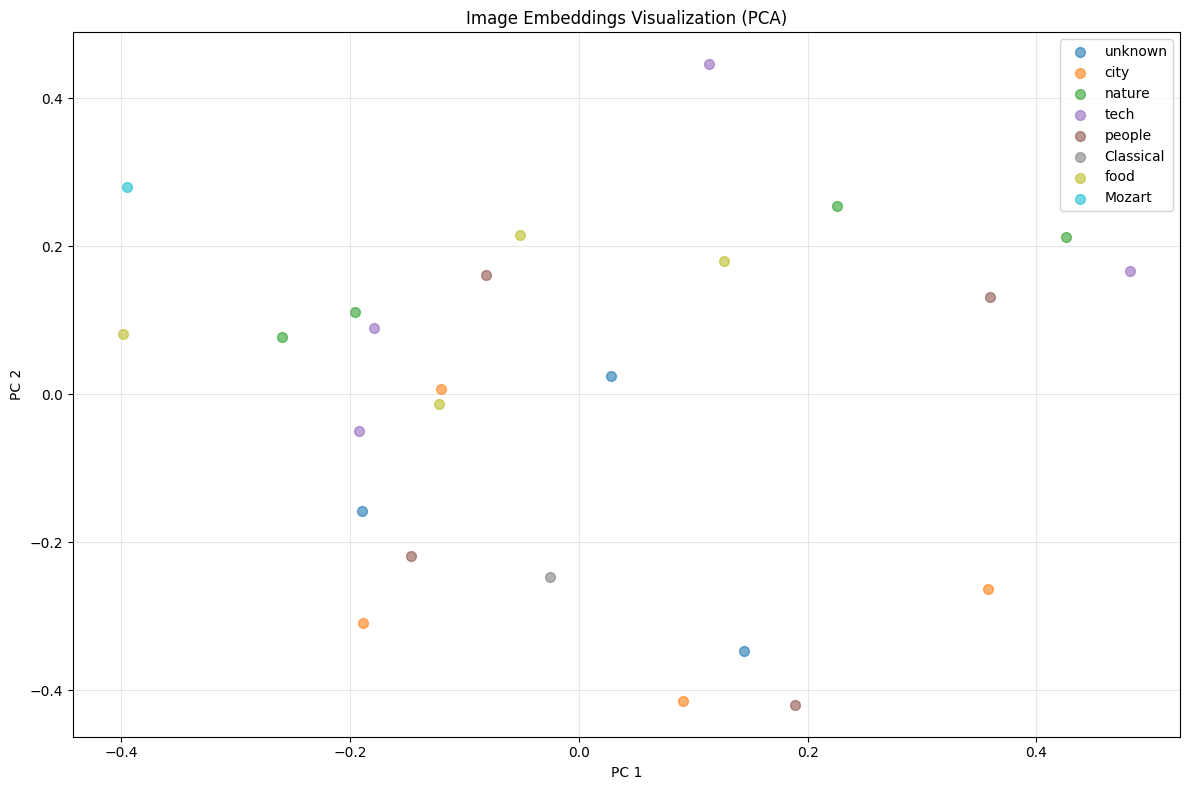

✅ Visualization saved to: ..\data\embeddings\embeddings_pca.png


In [18]:
# Cell 11: Visualize Embedding Space
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("\nVisualizing embedding space with PCA...")

# Use PCA to reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(image_embeddings)

# Plot
plt.figure(figsize=(12, 8))

# Color by category if available
if 'category' in metadata[0]:
    categories = [item['category'] for item in metadata]
    unique_categories = list(set(categories))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
    
    for i, category in enumerate(unique_categories):
        mask = np.array(categories) == category
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[i]],
            label=category,
            alpha=0.6,
            s=50
        )
    
    plt.legend()
else:
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=50)

plt.title('Image Embeddings Visualization (PCA)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()

visualization_path = Config.EMBEDDINGS_PATH / 'embeddings_pca.png'
plt.savefig(visualization_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved to: {visualization_path}")

In [19]:
# Cell 12: Embedding Statistics
print("\n📊 Embedding Statistics")
print("=" * 50)
print(f"Number of images: {len(image_embeddings)}")
print(f"Embedding dimension: {image_embeddings.shape[1]}")
print(f"Embedding mean: {image_embeddings.mean():.6f}")
print(f"Embedding std: {image_embeddings.std():.6f}")
print(f"Embedding min: {image_embeddings.min():.6f}")
print(f"Embedding max: {image_embeddings.max():.6f}")

# Check normalization
norms = np.linalg.norm(image_embeddings, axis=1)
print(f"\nEmbedding norms (should be ~1.0):")
print(f"  Mean: {norms.mean():.6f}")
print(f"  Std: {norms.std():.6f}")
print(f"  Min: {norms.min():.6f}")
print(f"  Max: {norms.max():.6f}")


📊 Embedding Statistics
Number of images: 25
Embedding dimension: 512
Embedding mean: -0.000265
Embedding std: 0.044193
Embedding min: -0.188277
Embedding max: 0.177532

Embedding norms (should be ~1.0):
  Mean: 1.000000
  Std: 0.000000
  Min: 1.000000
  Max: 1.000000


In [20]:
# Cell 13: Summary
summary = {
    'model': Config.CLIP_MODEL_NAME,
    'device': Config.DEVICE,
    'num_images': len(image_embeddings),
    'embedding_dim': int(image_embeddings.shape[1]),
    'embeddings_file': str(embeddings_file),
    'metadata_file': str(metadata_with_indices)
}

print("\n📋 Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

# Save summary
summary_file = Config.EMBEDDINGS_PATH / 'embedding_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Summary saved to: {summary_file}")


📋 Summary:
  model: openai/clip-vit-base-patch32
  device: cpu
  num_images: 25
  embedding_dim: 512
  embeddings_file: ..\data\embeddings\image_embeddings.npy
  metadata_file: ..\data\embeddings\metadata_with_indices.json

✅ Summary saved to: ..\data\embeddings\embedding_summary.json


In [21]:
# Cell 14: Next Steps
print("\n🎉 Embedding generation complete!")
print("\nNext steps:")
print("1. ✅ Image embeddings generated")
print("2. ✅ Text query encoding tested")
print("3. ⏭️  Run notebook 03_retrieval_experiments.ipynb")
print("4. ⏭️  Build vector database for efficient search")
print("5. ⏭️  Create API for search functionality")


🎉 Embedding generation complete!

Next steps:
1. ✅ Image embeddings generated
2. ✅ Text query encoding tested
3. ⏭️  Run notebook 03_retrieval_experiments.ipynb
4. ⏭️  Build vector database for efficient search
5. ⏭️  Create API for search functionality
